In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

In [2]:
csv_files = [k for k in os.listdir() if k.endswith(".csv")]

In [3]:
err_df = []
for k in csv_files:
    try:
        df = pd.read_csv(k, sep = ";",header=None)
        #print(df.columns.__len__())
        if df.columns.__len__() != 301:
            print(f"check cols in {k}")
            err_df.append(k)
    except:
        print(k)
print(f"err df: {err_df}")

analisys_pore_data_10013.csv
analisys_pore_data_28.csv
analisys_pore_data_13.csv
analisys_pore_data_32.csv
err df: []


In [4]:
dfs = []

for k in csv_files:
    try:
        df = pd.read_csv(k, sep = ";", header=None)
        number = k[k.rfind("_") + 1:k.rfind(".")]
        if len(number):
            number = number[-3:]
        df["Rock ID"] = number
        dfs.append(df)
    except:
        print(k)

analisys_pore_data_10013.csv
analisys_pore_data_28.csv
analisys_pore_data_13.csv
analisys_pore_data_32.csv


In [5]:
data = pd.concat(dfs, ignore_index=True)

In [6]:
data["Rock ID"] = data["Rock ID"].astype(int).astype(str)

In [7]:
data.isna().sum().value_counts()

1        282
0         17
4          1
362        1
40045      1
Name: count, dtype: int64

In [8]:
data = data.drop(columns=[300])
data.shape

(40045, 301)

In [9]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.to_list()

In [10]:
ren_dict = {}
for k in numeric_cols:
    ren_dict[k] = str(k)

In [11]:
data=data.rename(ren_dict)

In [12]:
data.shape

(40045, 301)

In [13]:
data[numeric_cols] = data[numeric_cols].replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=0)
data.shape

(39682, 301)

In [14]:
imputer = SimpleImputer(strategy="mean")
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

In [15]:
columns_to_drop = []
for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        zero_ratio = (data[col] == 0).mean()
        if zero_ratio > 0.5:
            columns_to_drop.append(col)
            
columns_to_drop.__len__()

164

In [16]:
data.drop(columns=columns_to_drop, inplace=True)

In [17]:
map_dict = {'10': "Кальциевый", 
 '02': "Чистый уратный", 
 '11': "", 
 '12': "", 
 '16': "Кальциевый", 
 '18': "Кальциевый",
 '19': "", 
 '25': "Кальциевый", 
 '27': "", 
 '28': "Уратный + кальций", 
 '30': "",
'31': "Кальциевый", 
'32': "Уратный + кальций", 
'33': "Чистый уратный", 
'34': "Кальциевый", 
'36': "Цистиновый", 
'37': "", 
'40': "", 
'43': "Кальциевый", 
'50': "Кальциевый", 
'51': "", 
'52': "Кальциевый",
'82': "", 
'53': "", 
'55': "", 
'2': "Чистый уратный", 
'9': "Кальциевый",
"153": "Цистиновый",
"155": "Уратный + кальций"}

In [18]:
map_dict = {'10': "", 
 '02': "Pure uric acid", 
 '11': "", 
 '12': "", 
 '16': "Calcium", 
 '18': "Calcium", 
 '19': "", 
 '25': "Calcium", 
 '27': "", 
 '28': "Uric acid with calcium", 
 '30': "",
'31': "Calcium", 
'32': "Uric acid with calcium", 
'33': "Pure uric acid", 
'34': "Calcium", 
'36': "Cystine", 
'37': "", 
'40': "", 
'43': "Calcium", 
'50': "Calcium", 
'51': "", 
'52': "Calcium",
'82': "", 
'53': "", 
'55': "", 
'2': "Pure uric acid", 
'9': "Calcium",
"155": "Uric acid with calcium",
"153": "Cystine"}

In [19]:
data["type"] = data["Rock ID"].map(map_dict)

/tmp/ipykernel_272971/1901726674.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["type"] = data["Rock ID"].map(map_dict)


In [20]:
data["type"].value_counts()

type
                          14836
Calcium                   12203
Pure uric acid             3604
Uric acid with calcium     3285
Cystine                    1832
Name: count, dtype: int64

In [21]:
data.shape

(39682, 138)

In [22]:
data["type"] = data["type"].astype(str)

In [23]:
# Создаем список значений для удаления
to_remove = ["", "","Cystine", "nan"]

# Фильтруем данные
data = data[~data["type"].isin(to_remove) & data["type"].notna()]

In [24]:
data_learning = data.copy()

In [25]:


# 1. Получение уникальных ID камней с их типами
unique_rocks = data_learning[['Rock ID', 'type']].drop_duplicates()

# 2. Стратифицированное разделение с гарантией всех типов в тесте
train_ids = pd.Series(dtype='object')
test_ids = pd.Series(dtype='object')

# Для каждого типа камней разделяем отдельно
for stone_type in unique_rocks['type'].unique():
    type_subset = unique_rocks[unique_rocks['type'] == stone_type]
    
    # Вычисляем размер тестовой выборки для типа (минимум 1 образец)
    n = len(type_subset)
    n_test = max(1, int(0.2 * n))  # Гарантируем хотя бы 1 образец
    
    # Разделение для текущего типа
    type_train, type_test = train_test_split(
        type_subset['Rock ID'],
        test_size=n_test,
        random_state=42
    )
    
    train_ids = pd.concat([train_ids, type_train])
    test_ids = pd.concat([test_ids, type_test])

# 3. Создание итоговых выборок
train_data = data_learning[data_learning['Rock ID'].isin(train_ids)]
test_data = data_learning[data_learning['Rock ID'].isin(test_ids)]

# 4. Проверка распределения
print("Train распределение:")
print(train_data['type'].value_counts(normalize=True))
print("\nTest распределение:")
print(test_data['type'].value_counts(normalize=True))

Train распределение:
type
Calcium                   0.713032
Uric acid with calcium    0.149069
Pure uric acid            0.137899
Name: proportion, dtype: float64

Test распределение:
type
Pure uric acid            0.377591
Calcium                   0.365005
Uric acid with calcium    0.257404
Name: proportion, dtype: float64


In [26]:
X_train = train_data.drop(columns = ['Rock ID', "type"], axis=1)
#y = train_data[['type', 'Rock ID']]
y_trian= train_data["type"]
le = LabelEncoder()
y_train_encoded= le.fit_transform(y_trian)
X_test = test_data.drop(columns = ['Rock ID', "type"], axis=1)

y_test= test_data["type"]
y_test_encoded= le.fit_transform(y_test)

In [27]:
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_train)


In [28]:
import matplotlib.patches as mpatches

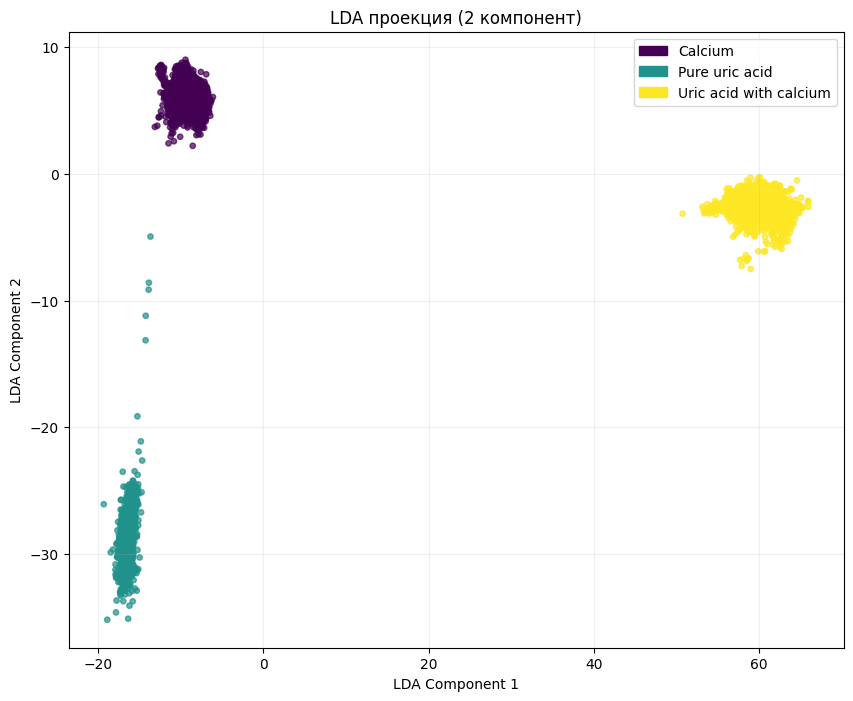

In [29]:


# Определение числа компонент
n_components = min(len(le.classes_) - 1, X_scaled.shape[1])

if n_components > 0:
    # Создание LDA модели
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    X_lda = lda.fit_transform(X_scaled, y_train_encoded)
    
    # Визуализация
    plt.figure(figsize=(10, 8))
    
    if n_components == 1:
        # Для 1 компоненты используем точечный график
        plt.scatter(X_lda, np.zeros_like(X_lda), c=y_train_encoded, cmap='viridis', alpha=0.7, s=15)
        plt.yticks([])
    else:
        # Для 2+ компонент
        scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y_train_encoded, cmap='viridis', alpha=0.7, s=15)
    
    plt.title(f'LDA проекция ({n_components} компонент)')
    plt.xlabel('LDA Component 1')
    if n_components > 1:
        plt.ylabel('LDA Component 2')
    
    # Создание легенды
    patches = [mpatches.Patch(color=plt.cm.viridis(i/(len(le.classes_)-1)), label=name) for i, name in enumerate(le.classes_)]
    plt.legend(handles=patches)
    plt.grid(alpha=0.2)
    plt.show()
else:
    print("LDA требует как минимум 2 класса для визуализации")

In [30]:
X_scaled

array([[-0.89472295, -0.96836792,  0.53029651, ..., -0.27910751,
        -0.35699674, -0.28611021],
       [-0.89046718, -0.97092779,  0.52304316, ..., -0.26117705,
        -0.3575497 , -0.28545408],
       [-0.88599187, -0.97156775,  0.53271429, ..., -0.2601376 ,
        -0.35837914, -0.28578214],
       ...,
       [-0.11479012, -0.02937828,  0.36830498, ..., -0.20530676,
        -0.33280481, -0.27446386],
       [-0.12070514, -0.04801728,  0.35258939, ..., -0.22375695,
        -0.32934882, -0.27495596],
       [-0.12536621, -0.05841672,  0.34775382, ..., -0.21466179,
        -0.33045474, -0.27380773]], shape=(15040, 136))

In [31]:
X_lda

array([[-11.95864046,   6.11870238],
       [-12.01095861,   6.31060886],
       [-12.01765543,   6.99894003],
       ...,
       [ -7.97617628,   5.16310363],
       [ -7.70692303,   4.72138161],
       [ -7.80056147,   4.91760316]], shape=(15040, 2))

In [32]:
X_test_scaled = scaler.transform(X_test)  # Масштабирование

In [33]:
X_test_lda = lda.transform(X_test_scaled)
X_test_lda

array([[ 55.57762587,  16.35491908],
       [ 55.72731539,  17.12352041],
       [ 56.68323165,  16.81485642],
       ...,
       [-32.98074017,   2.8333842 ],
       [-32.91507297,   2.88891445],
       [-33.21748828,   2.55182266]], shape=(4052, 2))

In [34]:
y_test_encoded

array([2, 2, 2, ..., 0, 0, 0], shape=(4052,))

In [35]:
y = train_data["type"].astype(str)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_lda, y, test_size=0.2, random_state=42)

In [37]:
X_train.shape

(12032, 2)

In [38]:
y_train_encoded = le.transform(y_train)
y_train_encoded 

array([0, 2, 1, ..., 0, 1, 2], shape=(12032,))

In [39]:
le.classes_

array(['Calcium', 'Pure uric acid', 'Uric acid with calcium'],
      dtype=object)

In [40]:

def plot_scatter(X_train, y_train_encoded, le = le):    

    class_names = le.classes_
    
    num = len(class_names)

    plt.figure(figsize=(12, 10))

    # Создаем палитру цветов для классов
    colors = ["#F83306", '#3399FF', '#33CC33', '#CC33FF'][:num]  # Оранжевый, Синий, Зеленый, Фиолетовый

    # Создаем словарь для названий классов
    class_dict = {i: name for i, name in enumerate(class_names)}

    # Рисуем каждый класс отдельно
    for class_idx in range(len(class_names)):
        # Выбираем только точки текущего класса
        mask = (y_train_encoded == class_idx)
        
        plt.scatter(
            X_train[mask, 0],
            X_train[mask, 1],
            c=colors[class_idx],
            label=class_dict[class_idx],
            alpha=0.8,
            s=60,
            edgecolor='w',
            linewidth=0.5
        )

    # Добавляем легенду с названиями классов
    plt.legend(title='Тип камней', title_fontsize=12, fontsize=11, loc='best', frameon=True, shadow=True)

    # Настраиваем оформление
    plt.title('Визуализация состава камней после LDA', fontsize=14, pad=20)
    plt.xlabel('Главная компонента 1', fontsize=12)
    plt.ylabel('Главная компонента 2', fontsize=12)
    plt.grid(alpha=0.2, linestyle='--')

    # Добавляем информационный текст
    plt.figtext(0.5, 0.01, 'Анализ состава камней', ha='center', fontsize=9, alpha=0.7)

    plt.tight_layout()
    plt.show()

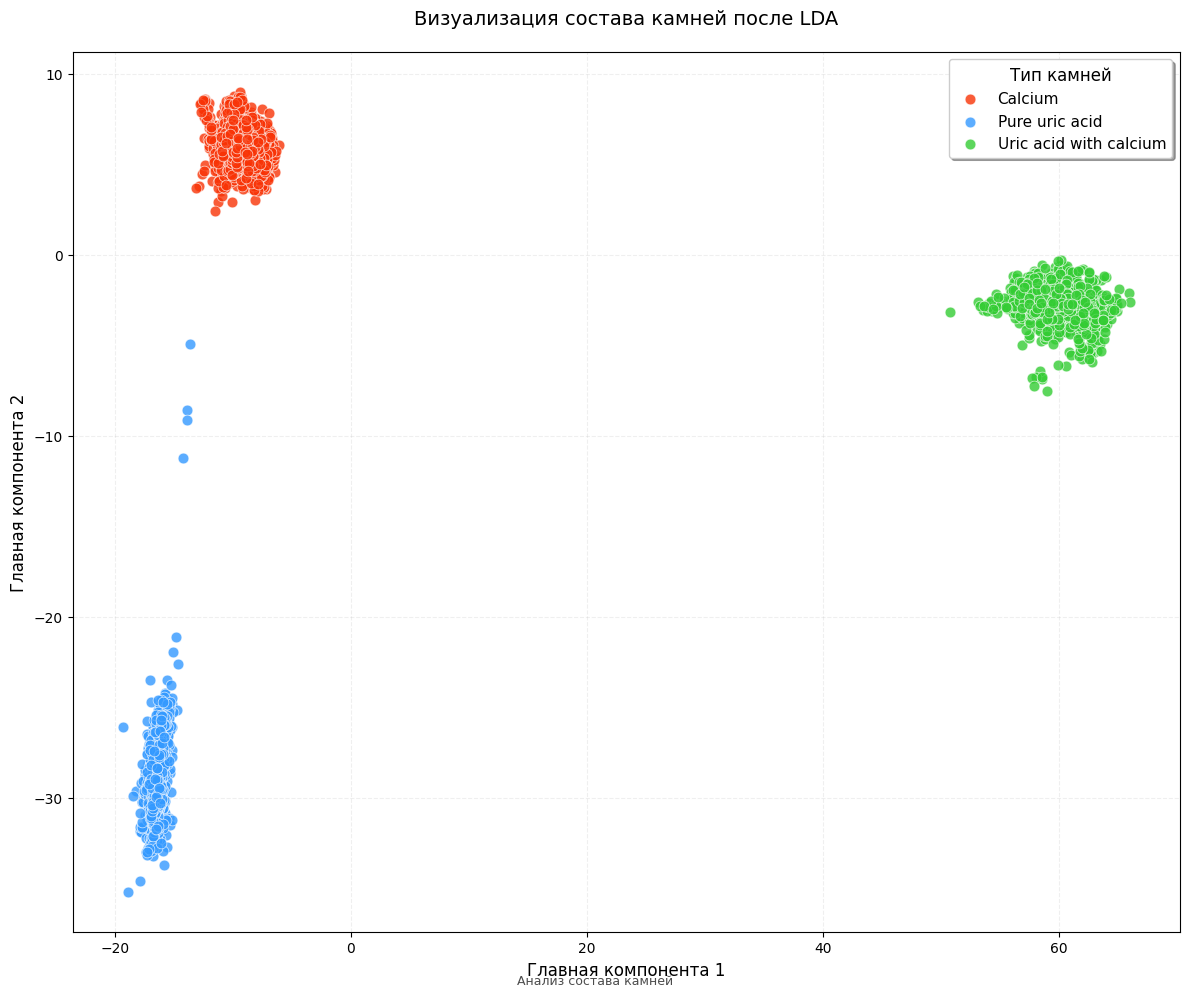

In [41]:
plot_scatter(X_train, y_train_encoded, le = le)

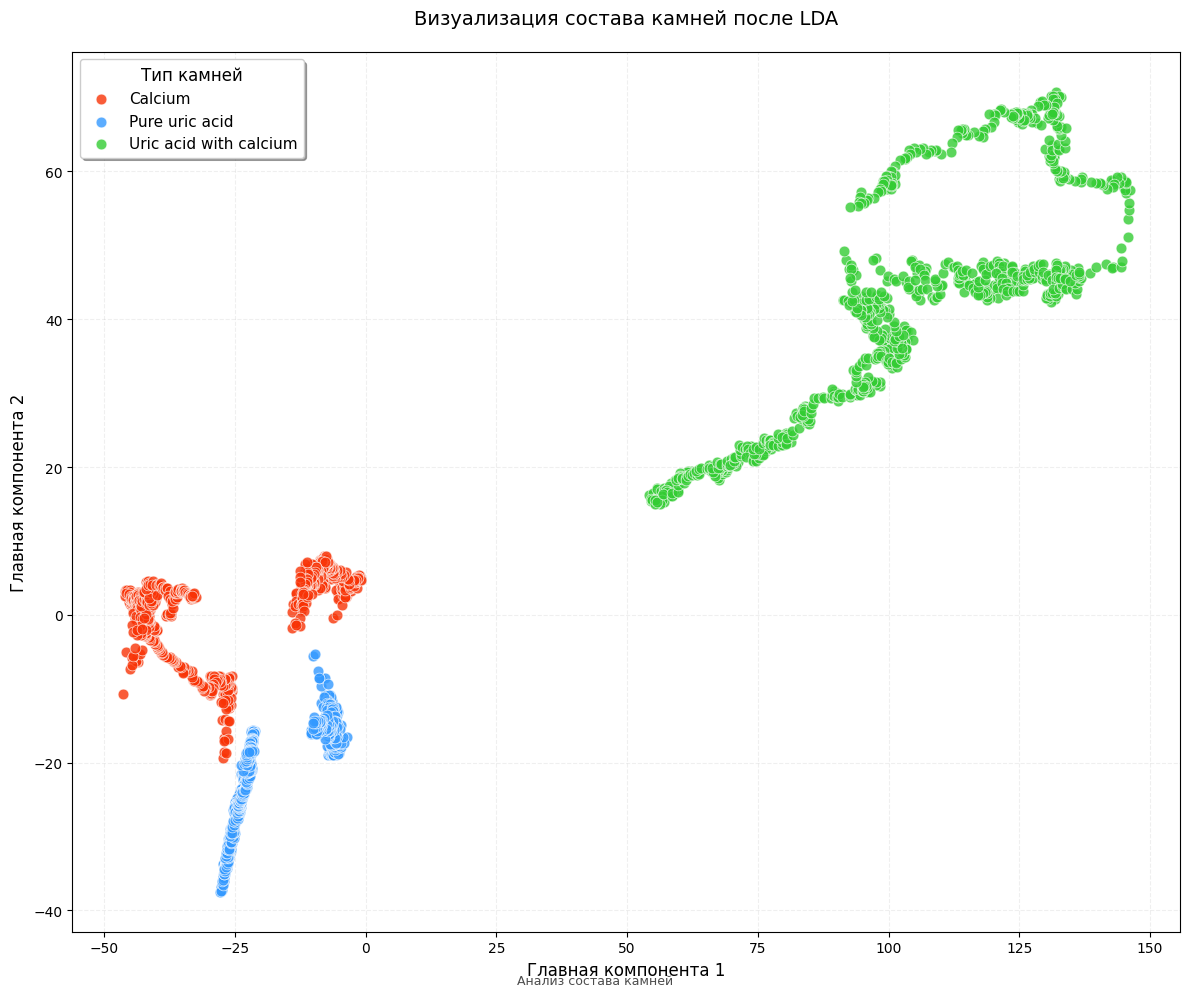

In [42]:
plot_scatter(X_test_lda, y_test_encoded, le = le)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
      dtype=object)

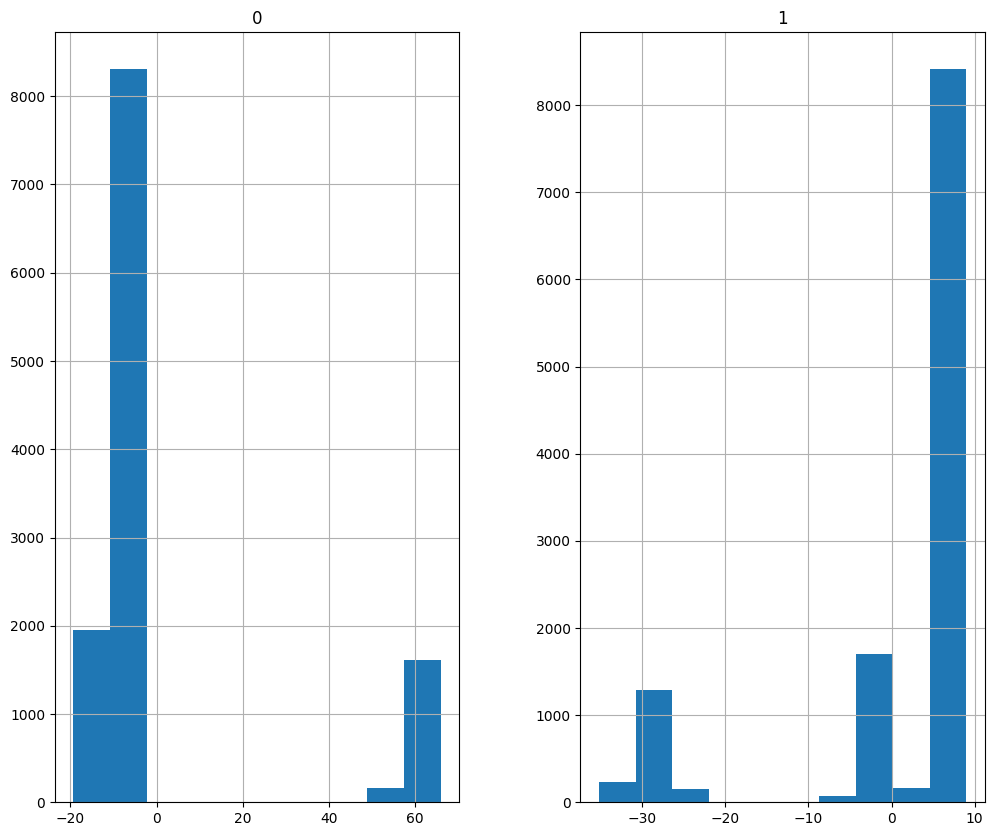

In [44]:
X_train_df = pd.DataFrame(X_train)
X_train_df.hist(figsize=(12,10))

In [45]:
from sklearn.preprocessing import PowerTransformer

# Инициализация трансформера
pt = PowerTransformer(method='yeo-johnson')

# Применение и конвертация в DataFrame
X_yeojohnson_df = pd.DataFrame(pt.fit_transform(X_train_df), columns=X_train_df.columns)

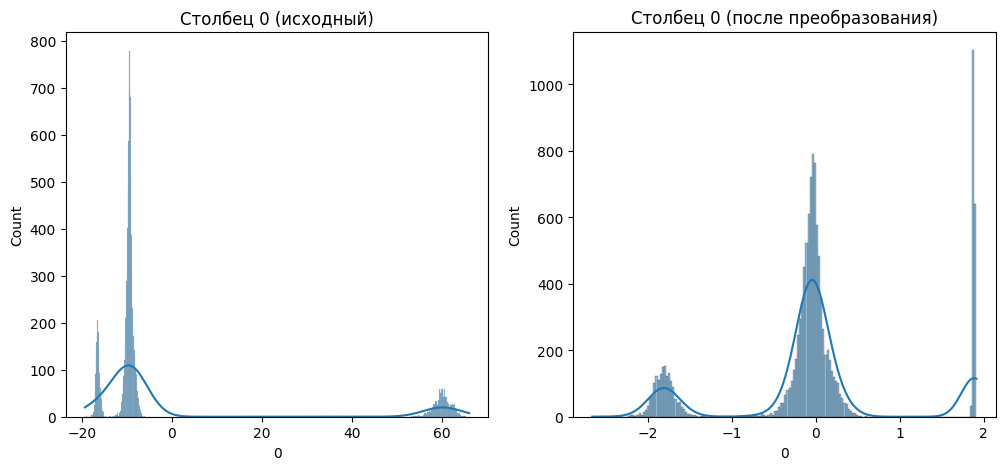

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# До преобразования
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(X_train_df[0], kde=True)
plt.title('Столбец 0 (исходный)')

# После QuantileTransformer
plt.subplot(1, 2, 2)
sns.histplot(X_yeojohnson_df[0], kde=True)
plt.title('Столбец 0 (после преобразования)')
plt.show()

In [47]:
X_train_lda_pt = pt.transform(X_train)
X_train_lda_pt

array([[ 0.09834377,  1.09892901],
       [ 1.88426017, -1.26362969],
       [-1.7818118 , -1.81306497],
       ...,
       [ 0.07241806,  0.38022092],
       [-1.72134443, -1.8287823 ],
       [ 1.90613349, -1.2197391 ]], shape=(12032, 2))

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
      dtype=object)

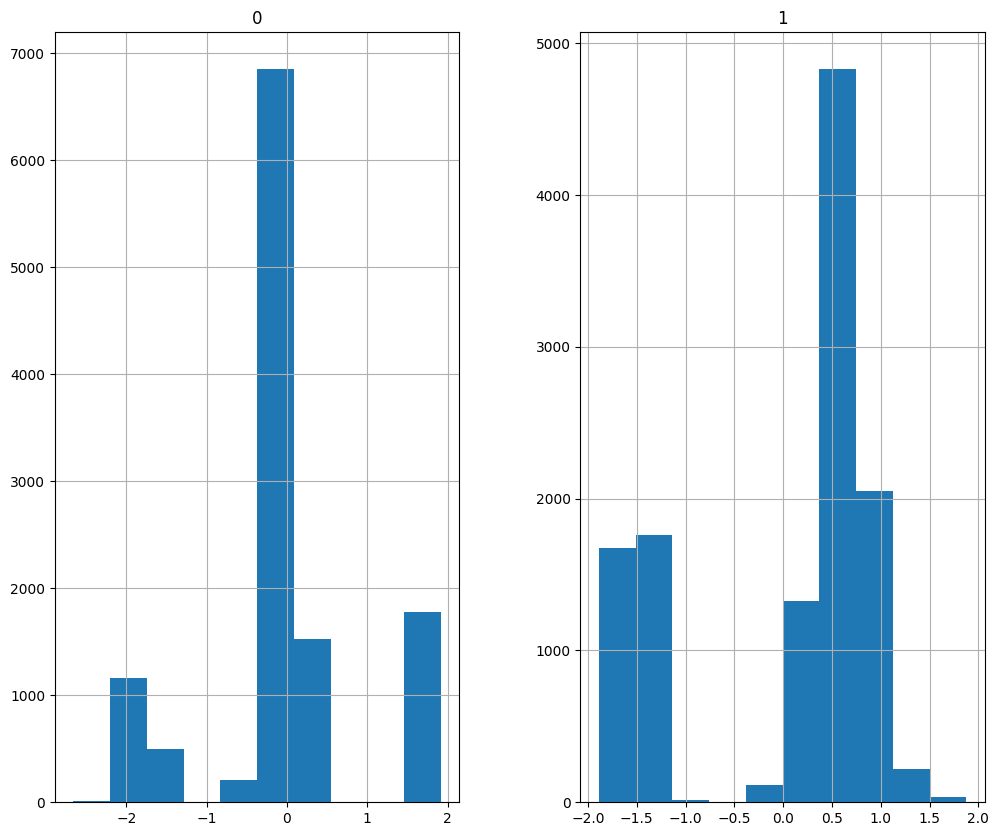

In [48]:
X_train_df_ = pd.DataFrame(X_train_lda_pt)
X_train_df_.hist(figsize=(12,10))

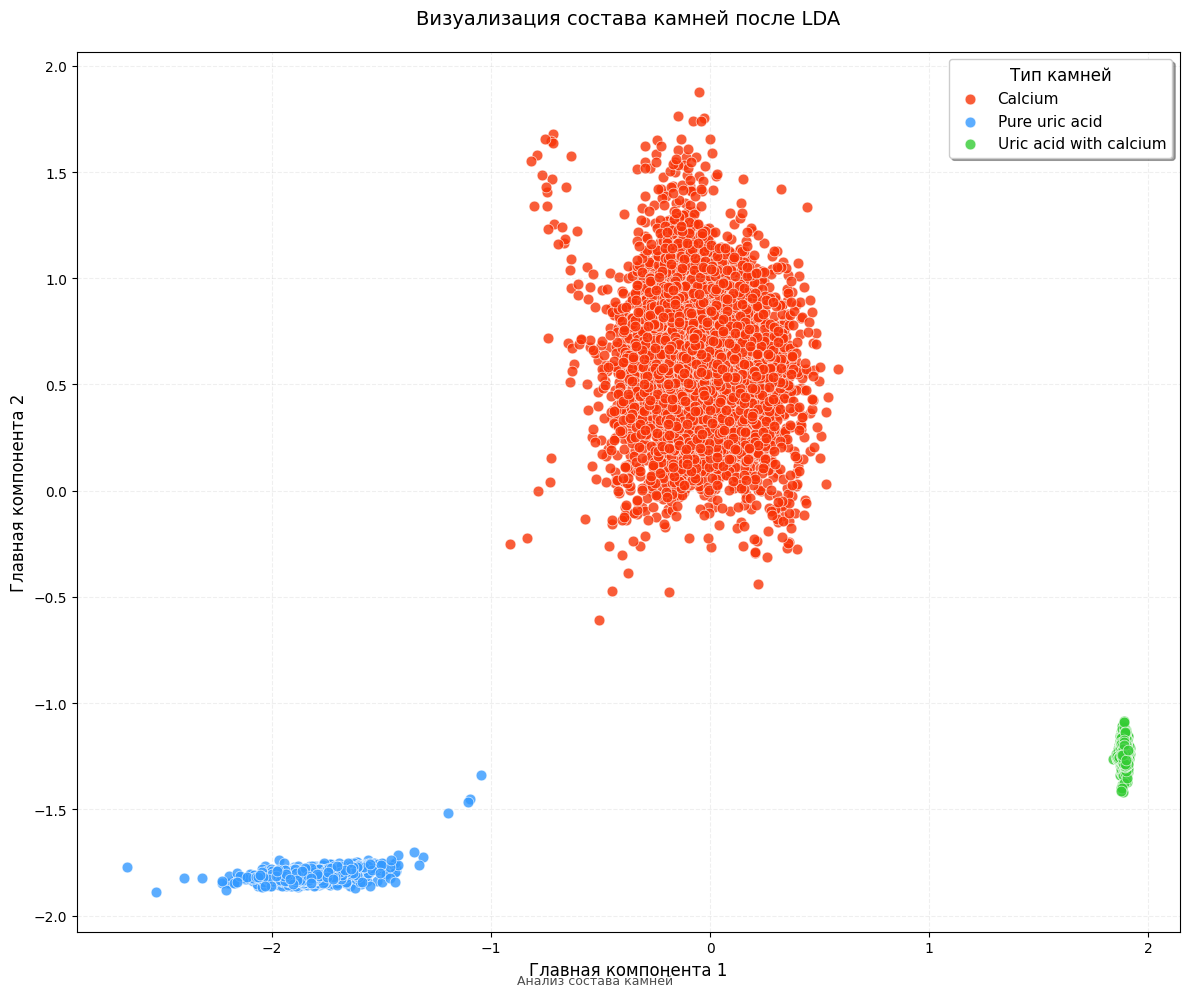

In [49]:
plot_scatter(X_train_lda_pt, y_train_encoded)

In [50]:
y_val_encoded = le.transform(y_val)

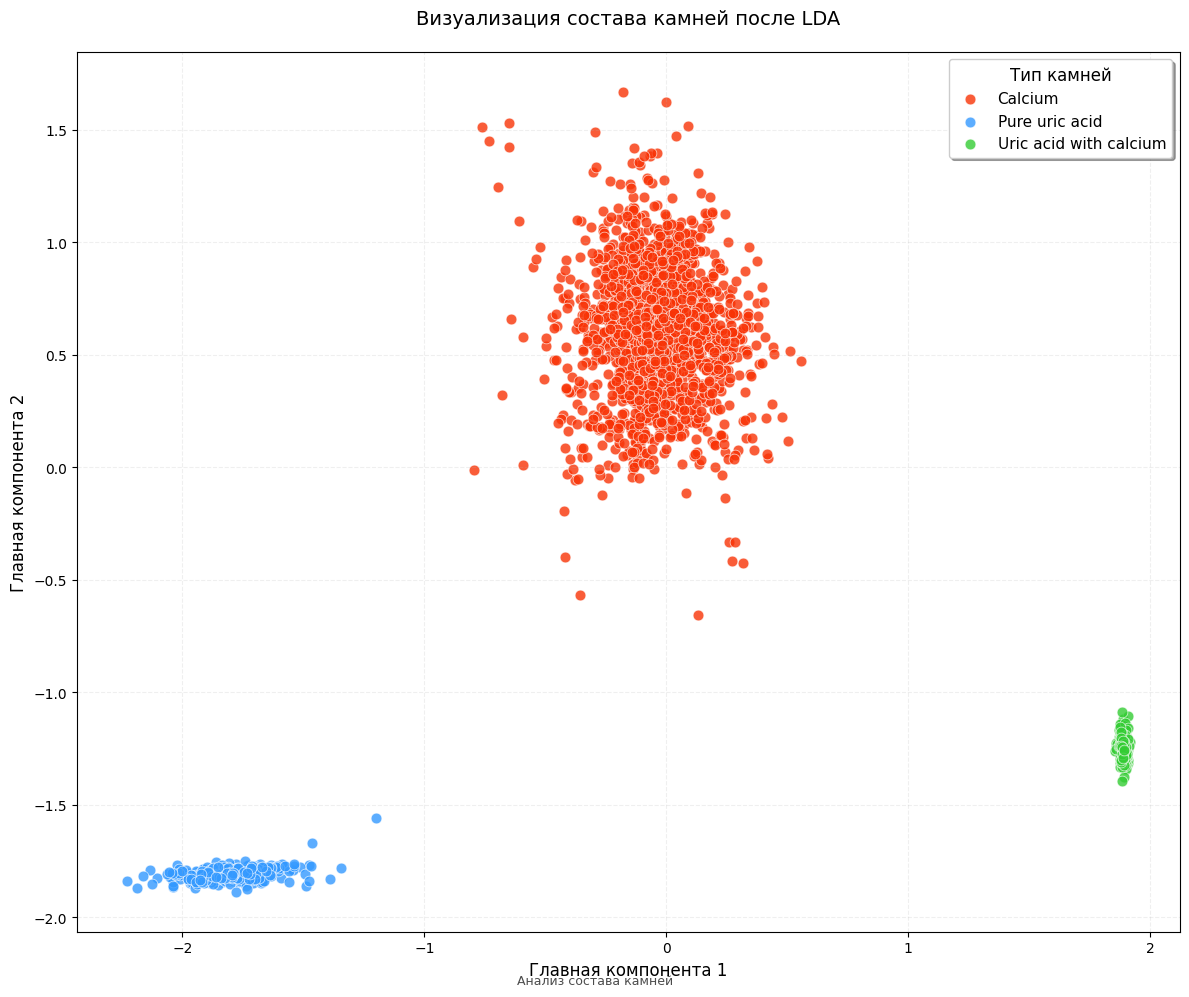

In [51]:
X_val_pt = pt.transform(X_val)
plot_scatter(X_val_pt, y_val_encoded)

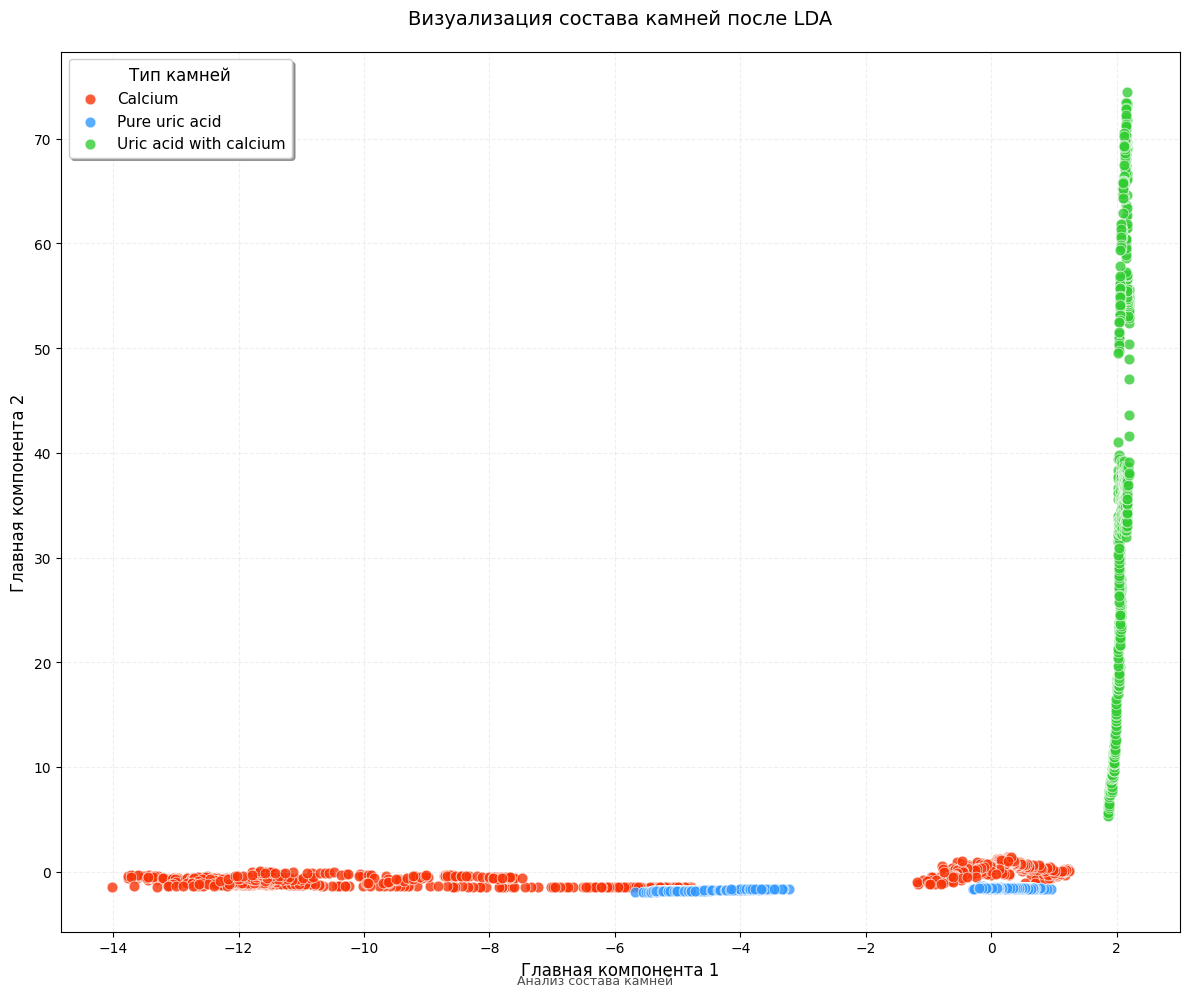

In [52]:
X_test_lda_pt = pt.transform(X_test_lda)
plot_scatter(X_test_lda_pt, y_test_encoded)

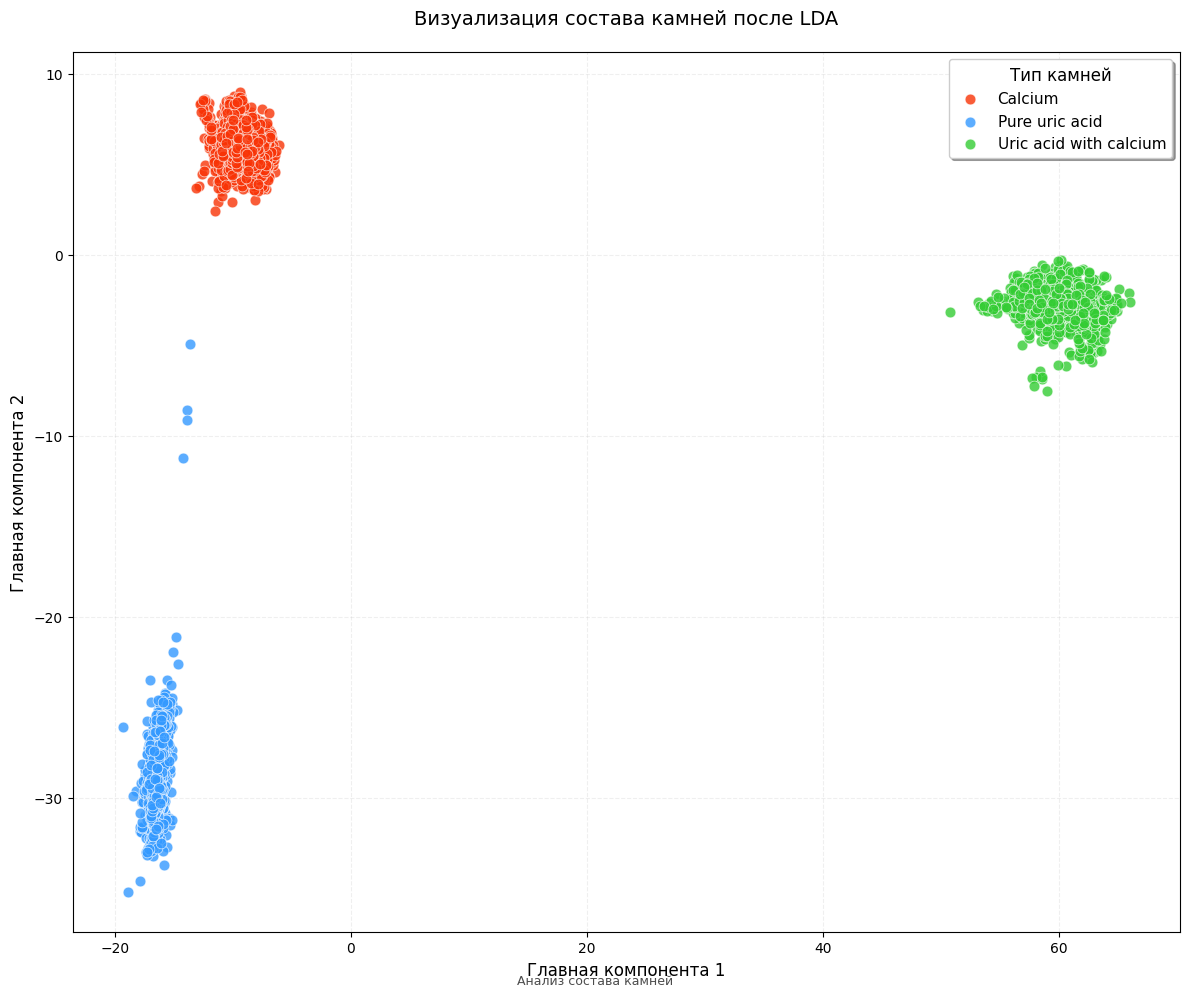

In [55]:
plot_scatter(X_train, y_train_encoded)

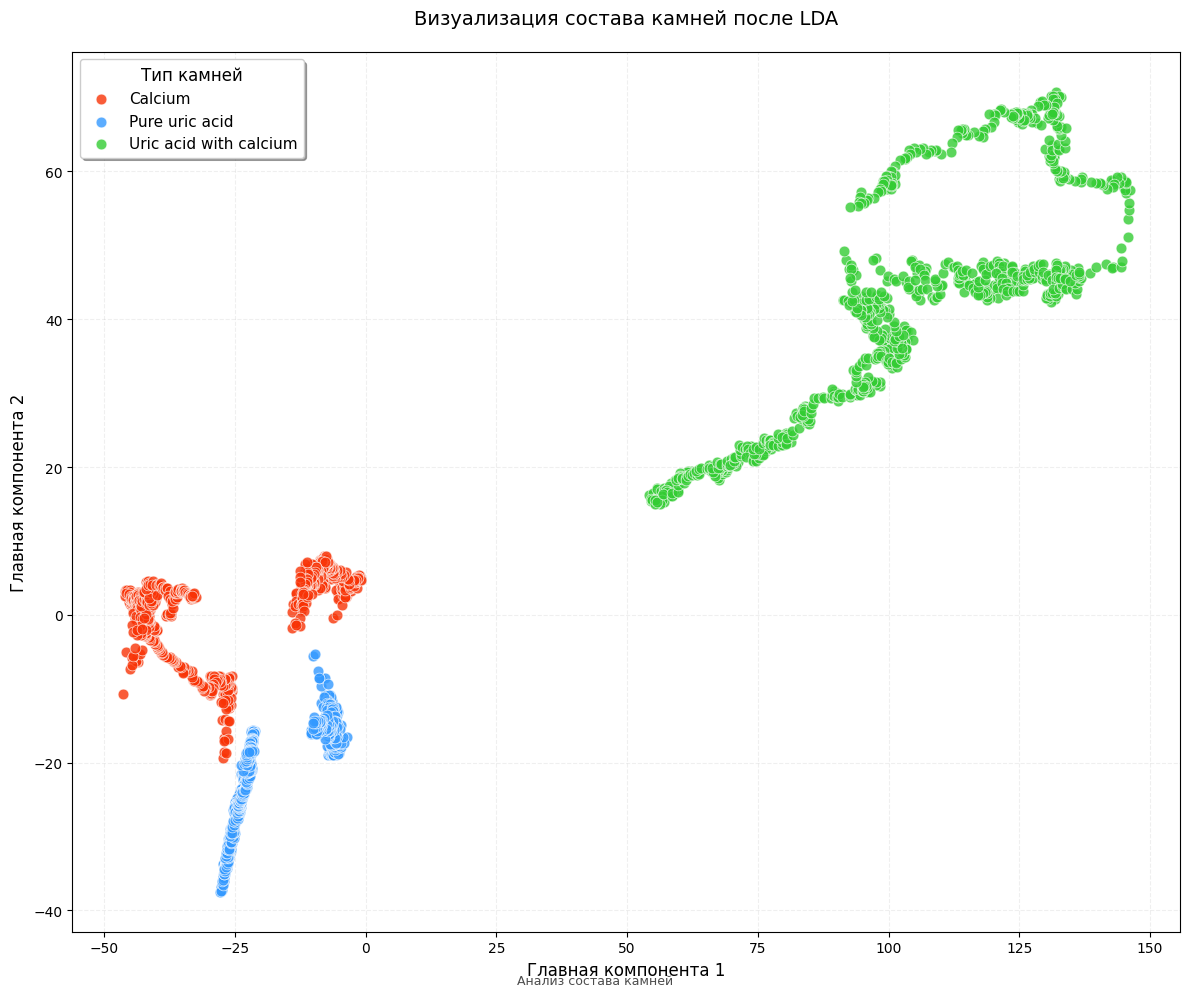

In [53]:
plot_scatter(X_test_lda, y_test_encoded)

In [56]:
log_reg = LogisticRegression(max_iter=5000,class_weight="balanced",C = np.float64(0.0001), l1_ratio = 0.1, penalty = 'elasticnet', solver = 'saga')
log_reg.fit(X_train_lda_pt, y_train_encoded)


LogisticRegression(C=np.float64(0.0001), class_weight='balanced', l1_ratio=0.1,
                   max_iter=5000, penalty='elasticnet', solver='saga')

In [58]:
data_to_plot = data.drop(columns=["Rock ID", "type"])
data_to_plot = lda.transform(data_to_plot)
data_to_plot = pt.transform(data_to_plot)
y_to_plot = le.transform(data[["Rock ID", "type"]]["type"])
data_to_plot

array([[-6.53480376e+07, -6.46037713e+01],
       [-6.50788551e+07, -6.45535061e+01],
       [-6.53921619e+07, -6.45428993e+01],
       ...,
       [-2.00019187e+08, -8.36337917e+01],
       [-2.00569090e+08, -8.37087101e+01],
       [-2.01783771e+08, -8.38207803e+01]], shape=(19092, 2))

In [59]:
y_to_plot

array([0, 0, 0, ..., 0, 0, 0], shape=(19092,))

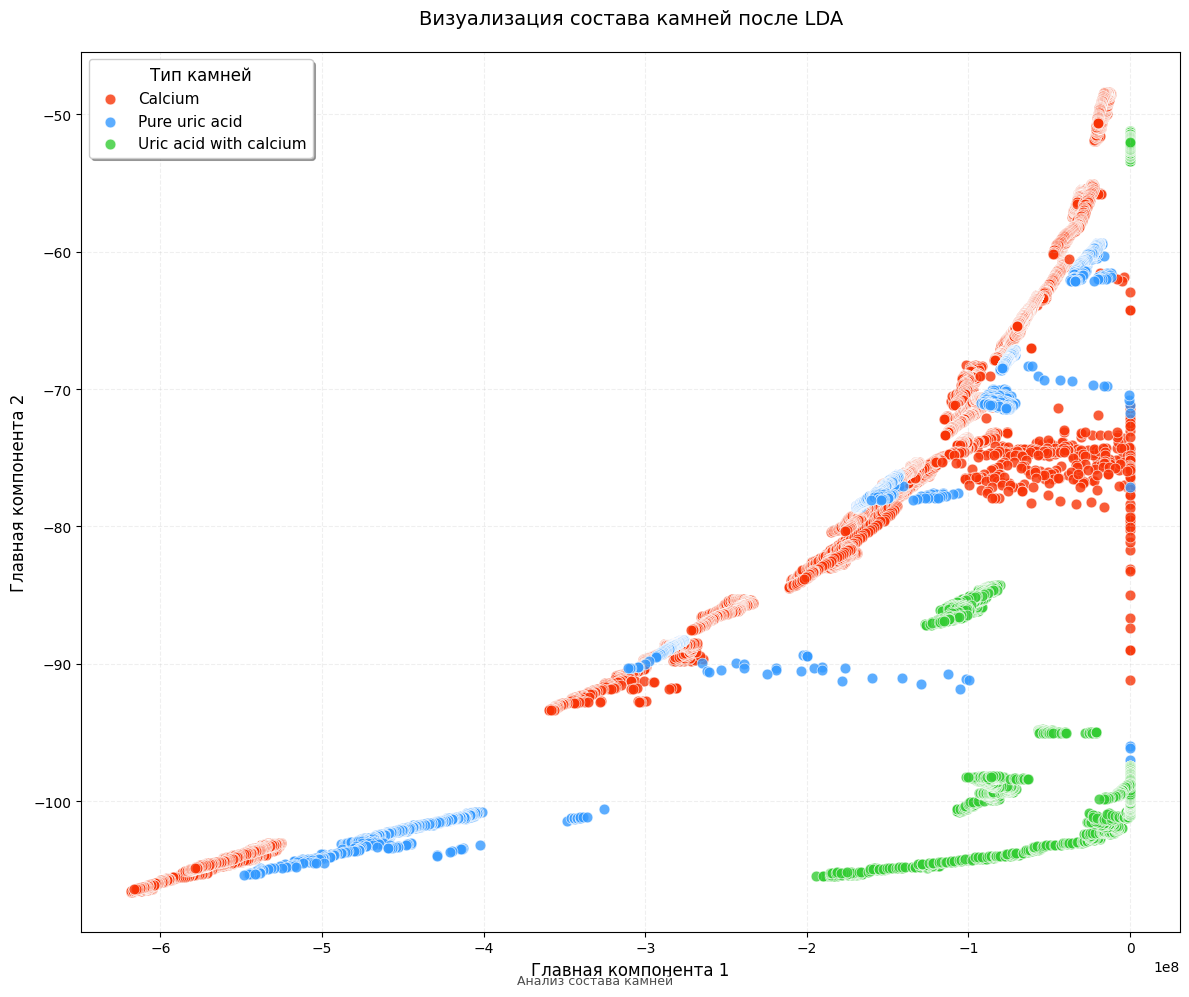

In [60]:
plot_scatter(data_to_plot, y_to_plot)

In [61]:
model = log_reg

In [62]:
model.coef_

array([[ 0.        ,  0.34436711],
       [-0.32669715, -0.17063817],
       [ 0.37327031, -0.06261783]])

In [63]:
model.intercept_

array([ 0.31104033, -0.20832321, -0.10271712])

In [64]:
y_pred = model.predict(X_test_lda_pt)
test_acc = accuracy_score(y_test_encoded, y_pred)
print(f"Test accuracy: {test_acc:.4f}")
print(classification_report(y_test_encoded, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))

Test accuracy: 0.3608
              precision    recall  f1-score   support

           0       0.38      0.43      0.40      1479
           1       0.51      0.54      0.53      1530
           2       0.00      0.00      0.00      1043

    accuracy                           0.36      4052
   macro avg       0.30      0.32      0.31      4052
weighted avg       0.33      0.36      0.35      4052

Confusion Matrix:
[[ 633  786   60]
 [   0  829  701]
 [1043    0    0]]


In [65]:
test_df = pd.DataFrame(X_test_lda)
test_df["y"] = y_test_encoded
test_df["y_pred"] = y_pred
test_df

,0,1,y,y_pred
0,55.577626,16.354919,2,0
1,55.727315,17.123520,2,0
2,56.683232,16.814856,2,0
3,56.522753,16.429387,2,0
4,56.338172,15.926511,2,0
...,...,...,...,...
4047,-32.476736,2.345245,0,1
4048,-32.978820,2.499484,0,1
4049,-32.980740,2.833384,0,1
4050,-32.915073,2.888914,0,1


In [66]:
le.classes_

array(['Calcium', 'Pure uric acid', 'Uric acid with calcium'],
      dtype=object)

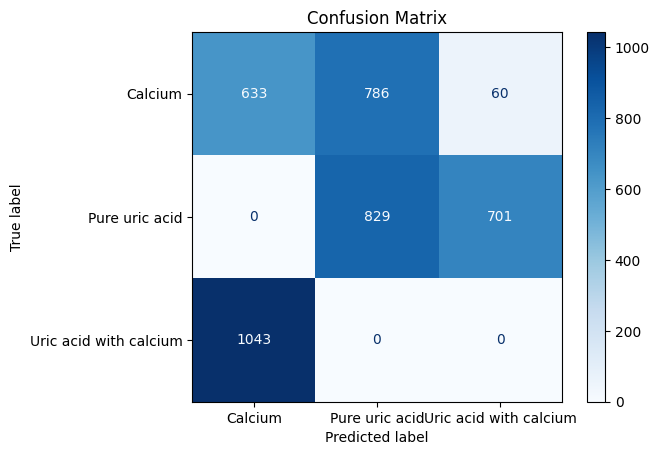

In [67]:


cm = confusion_matrix(test_df['y'], test_df["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=list(le.classes_))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [68]:
cm 

array([[ 633,  786,   60],
       [   0,  829,  701],
       [1043,    0,    0]])

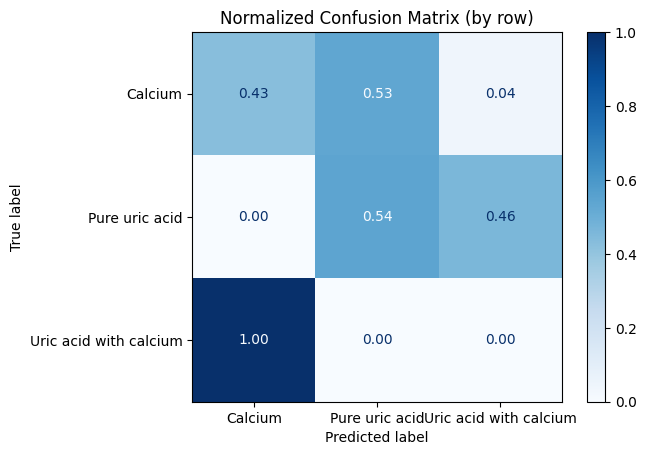

Normalized CM (row-wise):
[[0.428 0.531 0.041]
 [0.    0.542 0.458]
 [1.    0.    0.   ]]


In [69]:

# Нормируем матрицу по строкам (верные метки)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Создаем визуализацию с частотами
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized,
    display_labels=list(le.classes_)
)

# Настраиваем формат отображения (два знака после запятой)
disp.plot(cmap='Blues', values_format='.2f')  # Используйте '.1%' для процентов

plt.title('Normalized Confusion Matrix (by row)')
plt.show()

# Выводим числовое представление матрицы (опционально)
print("Normalized CM (row-wise):")
print(np.round(cm_normalized, 3))

In [70]:


print(classification_report(
    test_df['y'],
    test_df['y_pred'],
    target_names=list(le.classes_)
))

                        precision    recall  f1-score   support

               Calcium       0.38      0.43      0.40      1479
        Pure uric acid       0.51      0.54      0.53      1530
Uric acid with calcium       0.00      0.00      0.00      1043

              accuracy                           0.36      4052
             macro avg       0.30      0.32      0.31      4052
          weighted avg       0.33      0.36      0.35      4052



In [71]:
test_df

,0,1,y,y_pred
0,55.577626,16.354919,2,0
1,55.727315,17.123520,2,0
2,56.683232,16.814856,2,0
3,56.522753,16.429387,2,0
4,56.338172,15.926511,2,0
...,...,...,...,...
4047,-32.476736,2.345245,0,1
4048,-32.978820,2.499484,0,1
4049,-32.980740,2.833384,0,1
4050,-32.915073,2.888914,0,1


In [72]:
probs = model.predict_proba(X_test_lda)
probs

array([[1.15026817e-06, 1.95762244e-18, 9.99998850e-01],
       [1.48725075e-06, 1.62243480e-18, 9.99998513e-01],
       [9.18046807e-07, 8.59125959e-19, 9.99999082e-01],
       ...,
       [1.51292751e-04, 9.99848707e-01, 1.42180027e-10],
       [1.59056678e-04, 9.99840943e-01, 1.49762333e-10],
       [1.21133865e-04, 9.99878866e-01, 1.16862014e-10]], shape=(4052, 3))

In [73]:
probs_df = pd.DataFrame(probs)
probs_df

,0,1,2
0,1.150268e-06,1.957622e-18,9.999988e-01
1,1.487251e-06,1.622435e-18,9.999985e-01
2,9.180468e-07,8.591260e-19,9.999991e-01
3,8.331971e-07,1.002131e-18,9.999992e-01
4,7.274213e-07,1.204001e-18,9.999993e-01
...,...,...,...
4047,1.387247e-04,9.998613e-01,1.919364e-10
4048,1.274734e-04,9.998725e-01,1.373310e-10
4049,1.512928e-04,9.998487e-01,1.421800e-10
4050,1.590567e-04,9.998409e-01,1.497623e-10


In [74]:
test_df["prob_Calcium"] = probs_df[0]
test_df["prob_Uric acid"] = probs_df[1]
test_df["prob_Uric acid calcium"] = probs_df[2]

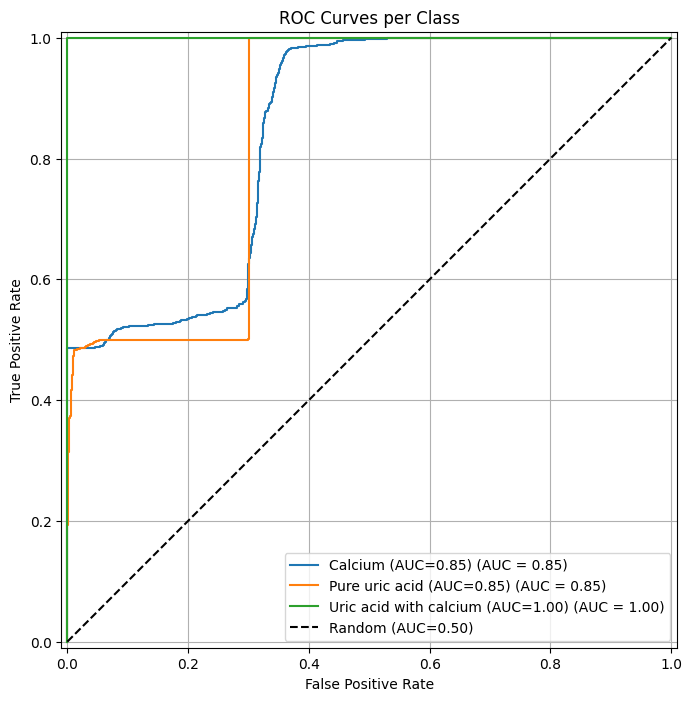

AUC Scores:
Calcium: 0.8457
Pure uric acid: 0.8478
Uric acid with calcium: 1.0000


In [75]:


# Преобразуем метки в one-hot encoding
y_true = label_binarize(test_df['y'], classes=[0,1,2,])
y_score = test_df[['prob_Calcium',# "prob_Cystine",
                   'prob_Uric acid', 'prob_Uric acid calcium']].values

fig, ax = plt.subplots(figsize=(10, 8))

# Создадим словарь для хранения AUC значений
auc_scores = {}

for i, cls in enumerate(le.classes_):
    # Вычисляем ROC кривую и AUC
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores[cls] = roc_auc
    
    # Строим кривую с подписью (включая AUC)
    RocCurveDisplay(
        fpr=fpr,
        tpr=tpr,
        roc_auc=roc_auc,
        estimator_name=f"{cls} (AUC={roc_auc:.2f})"
    ).plot(ax=ax)

# Добавляем диагональ (random classifier)
ax.plot([0, 1], [0, 1], 'k--', label="Random (AUC=0.50)")

ax.set_title("ROC Curves per Class")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc='lower right')  # Лучшее расположение для ROC
ax.grid()
plt.show()

# Дополнительно: выведем AUC значения
print("AUC Scores:")
for cls, score in auc_scores.items():
    print(f"{cls}: {score:.4f}")

In [76]:

n_classes = len(le.classes_)
y_test = test_df['y']
y_bin = label_binarize(y_test, classes=np.arange(n_classes))
# Macro-average AUC
macro_auc = roc_auc_score(y_bin, probs, average='macro')
print(f"Macro-average ROC AUC: {macro_auc:.4f}")

# Micro-average AUC
micro_auc = roc_auc_score(y_bin, probs, average='micro')
print(f"Micro-average ROC AUC: {micro_auc:.4f}")

Macro-average ROC AUC: 0.8978
Micro-average ROC AUC: 0.8740


In [77]:
test_df.to_excel("LDA_compressed_data_test_metrics.xlsx")